# Process gridded CMIP6 model data into variability data

__1. Process the gridded temperature data into timeseries for each model.__

Resample for time periods 2-120 years (to compare with 1900-2023 observations) to generate envelopes of internal variability for each region and each model.  

- Output is a dataArray for each model with indexed by time period length (3-120 years) and IPCC region containing a 95% confidence interval on unforced TAS trends.


Nathan notes that these models do the best job in CONUS:  MPI-ESM, GFDL-ESM2M, CESM1-CAM5, CanESM2.

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

__Processed Data directory:__  

Time series of TAS for each IPCC region.

In [2]:
pic_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'

#### Collect CESM1 PIC file paths.

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [4]:
cesm1_dir = 'CESM1/xagg/'

cesm1_pic_tas_files = glob.glob('%s/%s/*%s.?????????????.nc' % (pic_tseries_dir,cesm1_dir,cesm1_cmor_var_dict['tas']))
cesm1_pic_tas_files.sort()

In [5]:
mpi_dir = 'MPI-GE/xagg/'

mpi_pic_tas_files = glob.glob('%s/%s/*%s*r001i1850p3_??????-??????.nc' % (pic_tseries_dir,mpi_dir,'tas'))
mpi_pic_tas_files.sort()

In [6]:
canesm2_dir = 'CanESM2/xagg/'

canesm2_pic_tas_files = glob.glob('%s/%s/*%s*r1i1p1_??????-??????.nc' % (pic_tseries_dir,canesm2_dir,'tas'))
canesm2_pic_tas_files.sort()

In [7]:
esm2m_dir = 'ESM2M/xagg/'

esm2m_pic_tas_files = glob.glob('%s/%s/*%s*r1i1p1_??????-??????.nc' % (pic_tseries_dir,esm2m_dir,'tas'))
esm2m_pic_tas_files.sort()

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [8]:
def get_trends_allstartyears(data,duration,startyears,dim='year'):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    description = 'Trends for an unforced Pre-Industrial Control simulation sampled by timeseries startyear and duration.'
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different

        # Calculate the slope        
        _tsel_polyfit = _tsel.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop_vars('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
        
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [9]:
def compute_trends_wrapper(data,durations=np.arange(5,81,),**kwargs):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data['year'][0]
    last_year  = data['year'][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        _startyears = np.arange(first_year,last_year+2-duration,1)

        allvar_onedur_ds = get_trends_allstartyears(data,
                                                    duration=duration,
                                                    startyears=_startyears,
                                                    **kwargs
                                                   )
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
        
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list,dim='duration')
        
    # Add metadata
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName)})
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    return trends_allstartyear_allduration_ds

### Compute trends for all durations and save

#### CESM1-LE

Shifting the months up by one so that December fills the spot of January. Then I want to average in a way that masks if a nan is present.

In [10]:
cesm1_pic_tas_ds = xr.open_mfdataset(cesm1_pic_tas_files,chunks={'RegionIndex':1})

Standard calendar year definition (January through December).

In [11]:
%%time

# Compute annual average
cesm1_pic_tas_annual = cesm1_pic_tas_ds[cesm1_cmor_var_dict['tas']].groupby('time.year').mean('time')

cesm1_pic_tas_annual = cesm1_pic_tas_annual.compute()

CPU times: user 50.8 s, sys: 2.4 s, total: 53.2 s
Wall time: 51.4 s


In [12]:
%%time

cesm1_pic_tas_ensoshift = cesm1_pic_tas_ds[cesm1_cmor_var_dict['tas']].shift(time=1).groupby('time.year').mean(dim='time',skipna=False)

cesm1_pic_tas_annual_ensoshift = cesm1_pic_tas_ensoshift.isel(year=slice(1,None)).compute()

CPU times: user 53.6 s, sys: 1.84 s, total: 55.5 s
Wall time: 54 s


We see a small difference in the Greenland Area when the different sampling techniques are used.

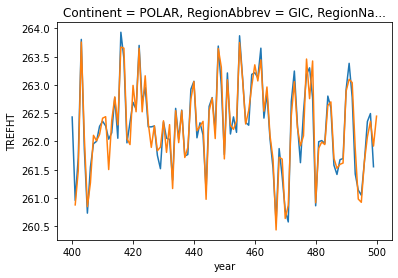

In [13]:
cesm1_pic_tas_annual.isel(RegionIndex=0,year=slice(None,100)).plot()

cesm1_pic_tas_annual_ensoshift.isel(RegionIndex=0,year=slice(None,100)).plot()

I see a small difference Equatorial Pacific too. So maybe this effect doesn't matter? At least for this model and its representation of ENSO?

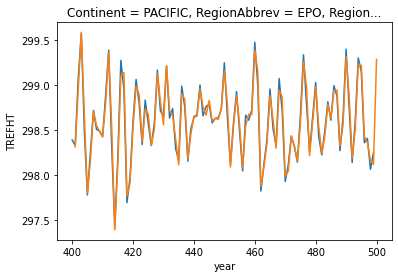

In [14]:
cesm1_pic_tas_annual.isel(RegionIndex=48,year=slice(None,100)).plot()

cesm1_pic_tas_annual_ensoshift.isel(RegionIndex=48,year=slice(None,100)).plot()

In [21]:
%%time

cesm1_pic_trends_all = compute_trends_wrapper(cesm1_pic_tas_annual, durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 12min 26s, sys: 4.5 s, total: 12min 30s
Wall time: 12min 31s


~12 minutes is totally reasonable!

In [22]:
cesm1_pic_trends_all.to_netcdf('%s/%s/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.1900trends.040001-220012.nc' % (pic_tseries_dir, cesm1_dir))
del cesm1_pic_trends_all, cesm1_pic_tas_annual

In [23]:
%%time

cesm1_pic_ensoshift_trends_all = compute_trends_wrapper(cesm1_pic_tas_annual_ensoshift, durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 12min 23s, sys: 3.2 s, total: 12min 26s
Wall time: 12min 26s


In [24]:
cesm1_pic_ensoshift_trends_all.to_netcdf('%s/%s/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.ENSOshift_1900trends.040001-220012.nc' % (pic_tseries_dir,cesm1_dir))
del cesm1_pic_ensoshift_trends_all, cesm1_pic_tas_annual_ensoshift

#### MPI-GE

In [25]:
mpi_pic_tas_ds = xr.open_mfdataset(mpi_pic_tas_files,chunks={'RegionIndex':1},use_cftime=True)

In [26]:
%%time

# Compute annual average
mpi_pic_tas_annual = mpi_pic_tas_ds['tas'].groupby('time.year').mean('time')

mpi_pic_tas_annual = mpi_pic_tas_annual.compute()

CPU times: user 54.7 s, sys: 3.22 s, total: 57.9 s
Wall time: 56.1 s


In [27]:
%%time

mpi_pic_trends_all = compute_trends_wrapper(mpi_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 13min 26s, sys: 2.09 s, total: 13min 28s
Wall time: 13min 28s


In [28]:
mpi_pic_trends_all.to_netcdf('%s/%s/tas_Amon_MPI-ESM_piControl_r001i1850p3.1900trends.185001-385012.nc' % (pic_tseries_dir,mpi_dir))

In [29]:
del mpi_pic_trends_all,mpi_pic_tas_annual,mpi_pic_tas_ds

#### CanESM2

In [30]:
canesm2_pic_tas_ds = xr.open_mfdataset(canesm2_pic_tas_files,chunks={'RegionIndex':1},use_cftime=True)

In [31]:
%%time

# Compute annual average
canesm2_pic_tas_annual = canesm2_pic_tas_ds['tas'].groupby('time.year').mean('time')

canesm2_pic_tas_annual = canesm2_pic_tas_annual.compute()

CPU times: user 26.6 s, sys: 967 ms, total: 27.6 s
Wall time: 26.7 s


In [32]:
%%time

canesm2_pic_trends_all = compute_trends_wrapper(canesm2_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 6min 23s, sys: 679 ms, total: 6min 23s
Wall time: 6min 23s


In [33]:
canesm2_pic_trends_all.to_netcdf('%s/%s/tas_Amon_CanESM2_piControl_r1i1p1.1900trends.201501-301012.nc' % (pic_tseries_dir,canesm2_dir))

In [34]:
del canesm2_pic_trends_all, canesm2_pic_tas_annual

#### ESM2M

In [35]:
esm2m_pic_tas_ds = xr.open_mfdataset(esm2m_pic_tas_files,chunks={'RegionIndex':1},use_cftime=True)

In [36]:
%%time

# Compute annual average
esm2m_pic_tas_annual = esm2m_pic_tas_ds['tas'].groupby('time.year').mean('time')

esm2m_pic_tas_annual = esm2m_pic_tas_annual.compute()

CPU times: user 31.8 s, sys: 1.73 s, total: 33.5 s
Wall time: 30.5 s


In [37]:
%%time

esm2m_pic_trends_all = compute_trends_wrapper(esm2m_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 3min 5s, sys: 431 ms, total: 3min 6s
Wall time: 3min 6s


In [38]:
esm2m_pic_trends_all.to_netcdf('%s/%s/tas_Amon_GFDL-ESM2M_piControl_r1i1p1.1900trends.000101-050012.nc' % (pic_tseries_dir,esm2m_dir))

In [39]:
del esm2m_pic_trends_all, esm2m_pic_tas_annual

NameError: name 'esm2m_pic_trends_all' is not defined